In [1]:
#library installations
%pip install pydicom SimpleITK numpy
%pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-2.2.6-cp310-cp310-macosx_10_9_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-macosx_10_9_x86_64.whl (21.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
monai 1.4.0 requires numpy<2.0,>=1.24, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install python-gdcm

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-image==0.22.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --force-reinstall numpy==1.25.2 scikit-image==0.22.0

  Using cached numpy-1.25.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.6 kB)
  Using cached scikit_image-0.22.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (13 kB)
  Using cached scipy-1.15.3-cp310-cp310-macosx_10_13_x86_64.whl.metadata (61 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp310-cp310-macosx_10_10_x86_64.whl.metadata (9.0 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.5.10-py3-none-any.whl.metadata (31 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached numpy-1.25.2-cp310-cp310-macosx_10_9_x86_64.whl (20.8 MB)
Using cached scikit_image-0.22.0-cp310-cp310-macosx_10_9_x86_64.whl (13.9 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached packaging-25.0-

In [6]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install monai

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import pydicom
import numpy as np
import SimpleITK as sitk

def load_dicom_volume(folder_path):
    # Load all DICOM files in the folder
    dicoms = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.dcm'):
            dicom = pydicom.dcmread(os.path.join(folder_path, filename))
            dicoms.append(dicom)

    # Sort slices by ImagePositionPatient or InstanceNumber
    dicoms.sort(key=lambda x: float(x.ImagePositionPatient[2]) if 'ImagePositionPatient' in x else int(x.InstanceNumber))

    # Stack slices into 3D array
    image_stack = np.stack([d.pixel_array for d in dicoms])

    # Get spacing info
    try:
        spacing = list(map(float, dicoms[0].PixelSpacing))  # in-plane spacing
        slice_thickness = float(dicoms[0].SliceThickness)
        spacing.append(slice_thickness)
    except:
        spacing = [1.0, 1.0, 1.0]  # fallback if tags missing

    return image_stack, spacing

In [12]:
def resample_volume(volume, original_spacing, new_spacing=[1.0, 1.0, 1.0]):
    original_spacing = np.array(original_spacing[::-1])  # DICOM order: z, y, x
    new_spacing = np.array(new_spacing)
    
    resize_factor = original_spacing / new_spacing
    new_shape = np.round(np.array(volume.shape) * resize_factor).astype(int)

    volume_sitk = sitk.GetImageFromArray(volume)
    volume_sitk.SetSpacing(original_spacing.tolist())

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing.tolist())
    resampler.SetSize([int(s) for s in new_shape[::-1]])
    resampler.SetInterpolator(sitk.sitkLinear)

    resampled = resampler.Execute(volume_sitk)
    return sitk.GetArrayFromImage(resampled)

In [13]:
def normalize_ct(volume, clip_min=-1000, clip_max=400):
    volume = np.clip(volume, clip_min, clip_max)
    volume = (volume - clip_min) / (clip_max - clip_min)  # normalize to [0, 1]
    return volume.astype(np.float32)

In [14]:
def load_and_process_dicom(folder_path):
    volume, spacing = load_dicom_volume(folder_path)
    resampled = resample_volume(volume, spacing, [1.0, 1.0, 1.0])
    normalized = normalize_ct(resampled)
    return normalized  # shape: (D, H, W)

In [15]:
import numpy as np

def get_10_montage_slices(volume):
    """Divide the volume into 10 sections and sample the center slice from each (sequentially)"""
    depth = volume.shape[0]  # z-dimension (axial slices)
    section_size = depth // 10
    slices = []

    for i in range(10):
        start = i * section_size
        end = (i + 1) * section_size if i < 9 else depth
        center_idx = (start + end) // 2
        slices.append(volume[center_idx])

    montage = np.stack(slices, axis=0)  # shape: (10, H, W), ordered top→bottom
    return montage

In [16]:
from skimage.transform import resize

def preprocess_slice(slice_2d):
    slice_2d = np.clip(slice_2d, -1000, 400)
    slice_2d = (slice_2d + 1000) / 1400
    slice_2d = resize(slice_2d, (224, 224), mode='reflect', anti_aliasing=True)
    return slice_2d.astype(np.float32)

In [17]:
def create_montage_tensor(volume):
    slices = get_10_montage_slices(volume)
    slices = [preprocess_slice(s) for s in slices]
    montage = np.stack(slices)  # shape: (10, H, W)
    montage = montage[:, np.newaxis, :, :]  # (10, 1, H, W)
    montage = np.transpose(montage, (1, 0, 2, 3))  # (1, 10, H, W)
    tensor = torch.tensor(montage, dtype=torch.float32)  # (1, 10, 224, 224)
    tensor = tensor.unsqueeze(0)  # add batch dim: (B=1, C=1, D=10, H, W)
    return tensor

In [18]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class DicomMontageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        patient_id = self.labels_df.iloc[idx]['patient_id']
        label = self.labels_df.iloc[idx]['label']
        dicom_folder = os.path.join(self.root_dir, patient_id)
        
        # Process volume
        volume = load_and_process_dicom(dicom_folder)
        tensor = create_montage_tensor(volume)

        if self.transform:
            tensor = self.transform(tensor)
            
        return tensor.squeeze(0), torch.tensor(label, dtype=torch.long)

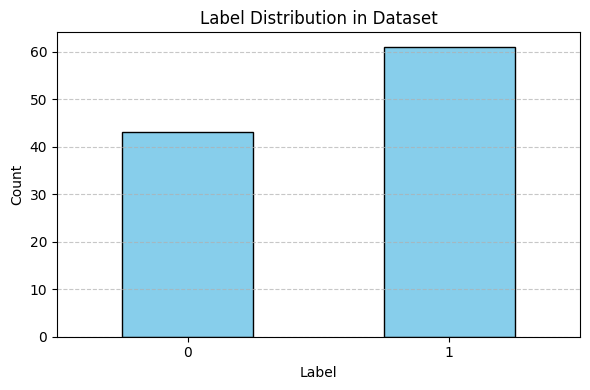

In [19]:
#visualize the data breakdown
import matplotlib.pyplot as plt

# Load your CSV file
csv_file = 'dataset/labels_binary.csv'
labels_df = pd.read_csv(csv_file)

# Count each label type
label_counts = labels_df['label'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Dataset')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)$

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
#partition the dataset into train:validate:test 75%:12.5%:12.5%

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

# Wrap dataset access in try-except to catch loading errors
def safe_get_label(dataset, idx):
    try:
        _, label = dataset[idx]
        return label
    except Exception as e:
        # Attempt to get patient ID if available; adjust attribute as per your dataset
        patient_id = getattr(dataset, 'patient_ids', None)
        pid = patient_id[idx] if patient_id is not None else f"index {idx}"
        print(f"Warning: Skipping patient {pid} due to error: {e}")
        return None

# full dataset and loader (keep loader for convenience, may skip corrupted later)
dataset = DicomMontageDataset(csv_file='dataset/labels_multi.csv', root_dir='dataset')
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Collect valid indices and labels with error handling
valid_indices = []
valid_labels = []
print("Extracting labels and filtering corrupted samples:")
for idx in tqdm(range(len(dataset))):
    label = safe_get_label(dataset, idx)
    if label is not None:
        valid_indices.append(idx)
        valid_labels.append(label)

# Now do stratified splits on filtered valid data only
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_rel_idx, temp_rel_idx in sss1.split(X=valid_labels, y=valid_labels):
    pass

# Get absolute indices from relative
train_idx = [valid_indices[i] for i in train_rel_idx]
temp_idx = [valid_indices[i] for i in temp_rel_idx]

# Split temp into val and test (50% each)
temp_labels = [valid_labels[i] for i in temp_rel_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_rel_idx, test_rel_idx in sss2.split(X=temp_labels, y=temp_labels):
    pass

val_idx = [temp_idx[i] for i in val_rel_idx]
test_idx = [temp_idx[i] for i in test_rel_idx]

# Create subsets using filtered and split indices
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Extracting labels and filtering corrupted samples:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [06:55<00:00,  4.00s/it]


In [36]:
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 78
Validation samples: 13
Test samples: 13


In [21]:
!pip install torch_optimizer

In [22]:
# from monai.networks.nets import SEResNet50
# import torch
# import torch.nn as nn
# from torch.optim import Adam, AdamW, SGD, RMSprop
# from torch_optimizer import RAdam
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
# import copy

# # Define available optimizers
# def get_optimizer(opt_name, model_params, lr=1e-4):
#     if opt_name == "Adam":
#         return Adam(model_params, lr=lr)
#     elif opt_name == "AdamW":
#         return AdamW(model_params, lr=lr)
#     elif opt_name == "RAdam":
#         return RAdam(model_params, lr=lr)
#     elif opt_name == "SGD":
#         return SGD(model_params, lr=lr, momentum=0.9)
#     elif opt_name == "RMSprop":
#         return RMSprop(model_params, lr=lr, momentum=0.9)
#     else:
#         raise ValueError("Unknown optimizer")

# # Define available schedulers
# def get_scheduler(sched_name, optimizer):
#     if sched_name == "StepLR":
#         return StepLR(optimizer, step_size=2, gamma=0.5)
#     elif sched_name == "ReduceLROnPlateau":
#         return ReduceLROnPlateau(optimizer, mode='max', patience=1, factor=0.5, verbose=False)
#     elif sched_name == "CosineAnnealingLR":
#         return CosineAnnealingLR(optimizer, T_max=5)
#     else:
#         raise ValueError("Unknown scheduler")

# # Optimizers and schedulers to test
# optimizers_to_test = ["Adam", "AdamW", "RAdam", "SGD", "RMSprop"]
# schedulers_to_test = ["StepLR", "ReduceLROnPlateau", "CosineAnnealingLR"]

# # Results dict
# results = {}

# # Training loop
# for opt_name in optimizers_to_test:
#     for sched_name in schedulers_to_test:
#         print(f"\n🔧 Testing Optimizer: {opt_name} + Scheduler: {sched_name}")

#         # Reinitialize model
#         model = SEResNet50(spatial_dims=3, in_channels=1, num_classes=2)
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         model = model.to(device)

#         optimizer = get_optimizer(opt_name, model.parameters(), lr=1e-4)
#         scheduler = get_scheduler(sched_name, optimizer)
#         criterion = nn.CrossEntropyLoss()

#         best_val_acc = 0
#         num_epochs = 5  # Keep short for testing

#         for epoch in range(num_epochs):
#             model.train()
#             running_loss, correct, total = 0.0, 0, 0

#             for inputs, labels in train_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#                 running_loss += loss.item()
#                 _, predicted = outputs.max(1)
#                 correct += predicted.eq(labels).sum().item()
#                 total += labels.size(0)

#             train_acc = 100 * correct / total
#             print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

#             # Validation
#             model.eval()
#             val_correct, val_total, val_loss = 0, 0, 0.0
#             with torch.no_grad():
#                 for val_inputs, val_labels in val_loader:
#                     val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
#                     val_outputs = model(val_inputs)
#                     loss = criterion(val_outputs, val_labels)
#                     val_loss += loss.item()
#                     _, val_pred = val_outputs.max(1)
#                     val_correct += val_pred.eq(val_labels).sum().item()
#                     val_total += val_labels.size(0)

#             val_acc = 100 * val_correct / val_total
#             print(f"Validation Accuracy: {val_acc:.2f}%")

#             best_val_acc = max(best_val_acc, val_acc)

#             # Step scheduler
#             if sched_name == "ReduceLROnPlateau":
#                 scheduler.step(val_acc)  # uses validation metric
#             else:
#                 scheduler.step()

#         results[f"{opt_name}+{sched_name}"] = best_val_acc

# # Print summary
# print("\n📊 Best Optimizer+Scheduler Performance:")
# for combo, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
#     print(f"{combo}: {acc:.2f}%")



🔧 Testing Optimizer: Adam + Scheduler: StepLR
Epoch 1, Loss: 6.9326, Train Acc: 55.13%
Validation Accuracy: 46.15%
Epoch 2, Loss: 6.8901, Train Acc: 56.41%
Validation Accuracy: 46.15%
Epoch 3, Loss: 7.0489, Train Acc: 55.13%
Validation Accuracy: 46.15%
Epoch 4, Loss: 6.7801, Train Acc: 62.82%
Validation Accuracy: 46.15%
Epoch 5, Loss: 6.8738, Train Acc: 57.69%
Validation Accuracy: 46.15%

🔧 Testing Optimizer: Adam + Scheduler: ReduceLROnPlateau


/Users/Sidra/opt/anaconda3/envs/mlct/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 7.7477, Train Acc: 47.44%
Validation Accuracy: 53.85%
Epoch 2, Loss: 6.8674, Train Acc: 56.41%
Validation Accuracy: 46.15%
Epoch 3, Loss: 6.7511, Train Acc: 58.97%
Validation Accuracy: 46.15%
Epoch 4, Loss: 7.2547, Train Acc: 55.13%
Validation Accuracy: 46.15%
Epoch 5, Loss: 6.9600, Train Acc: 50.00%
Validation Accuracy: 46.15%

🔧 Testing Optimizer: Adam + Scheduler: CosineAnnealingLR
Epoch 1, Loss: 7.0183, Train Acc: 50.00%
Validation Accuracy: 46.15%
Epoch 2, Loss: 6.8953, Train Acc: 58.97%
Validation Accuracy: 53.85%
Epoch 3, Loss: 6.8119, Train Acc: 57.69%
Validation Accuracy: 46.15%
Epoch 4, Loss: 6.9071, Train Acc: 53.85%
Validation Accuracy: 53.85%
Epoch 5, Loss: 6.6454, Train Acc: 60.26%
Validation Accuracy: 53.85%

🔧 Testing Optimizer: AdamW + Scheduler: StepLR
Epoch 1, Loss: 7.0828, Train Acc: 57.69%
Validation Accuracy: 46.15%
Epoch 2, Loss: 6.8316, Train Acc: 53.85%
Validation Accuracy: 53.85%
Epoch 3, Loss: 7.2795, Train Acc: 58.97%
Validation Accuracy: 46.1

In [37]:
#Create the model

from monai.networks.nets import SEResNet50
import torch.nn as nn
import torch

# Load pretrained SE-ResNet50 3D
# Create SE-ResNet50 3D model for binary classification
model = SEResNet50(
    spatial_dims=3,
    in_channels=1,      # Use this instead of n_input_channels
    num_classes=4       # For binary classification
)

# Optional: move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Optionally freeze early layers to prevent fine tuning the whole network
# for param in model.layer1.parameters():
#     param.requires_grad = False

num_epochs = 10

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # (B, 1, 10, 224, 224)=
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = val_outputs.max(1)
            val_correct += val_predicted.eq(val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")


Epoch 1/10, Train Loss: 12.0200, Train Accuracy: 30.77%
Validation Loss: 2.5373, Validation Accuracy: 38.46%

Epoch 2/10, Train Loss: 11.4162, Train Accuracy: 42.31%
Validation Loss: 2.2823, Validation Accuracy: 38.46%

Epoch 3/10, Train Loss: 11.3675, Train Accuracy: 34.62%
Validation Loss: 2.2980, Validation Accuracy: 38.46%

Epoch 4/10, Train Loss: 11.0489, Train Accuracy: 44.87%
Validation Loss: 2.2797, Validation Accuracy: 38.46%

Epoch 5/10, Train Loss: 11.1140, Train Accuracy: 39.74%
Validation Loss: 2.1679, Validation Accuracy: 38.46%

Epoch 6/10, Train Loss: 11.1526, Train Accuracy: 41.03%
Validation Loss: 2.2251, Validation Accuracy: 38.46%

Epoch 7/10, Train Loss: 11.1624, Train Accuracy: 44.87%
Validation Loss: 2.1451, Validation Accuracy: 38.46%

Epoch 8/10, Train Loss: 10.9746, Train Accuracy: 47.44%
Validation Loss: 2.1758, Validation Accuracy: 38.46%

Epoch 9/10, Train Loss: 11.2663, Train Accuracy: 44.87%
Validation Loss: 2.1246, Validation Accuracy: 46.15%

Epoch 10/1

In [27]:
!pip install seaborn

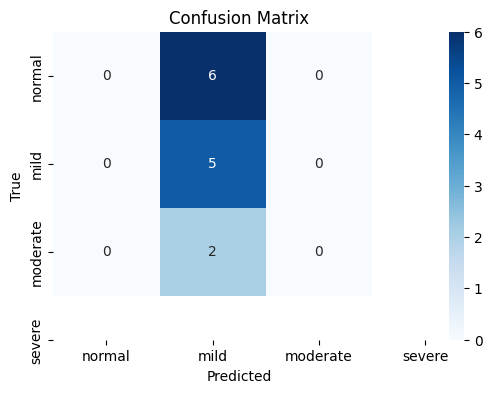

Test Loss: 1.1685
Test Accuracy: 38.46%
Precision: 0.1479
Recall: 0.3846


(1.168537437915802,
 38.46153846153846,
 0.14792899408284024,
 0.38461538461538464)

In [38]:
#Test the model 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def test_model(model, test_loader, criterion, device, class_names):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation for speed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

     # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(cm.shape[0]),
                yticklabels=class_names if class_names else range(cm.shape[0]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision and Recall
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return avg_loss, accuracy, precision, recall

class_names = ["normal", "mild", "moderate", "severe"] 
test_model(model, test_loader, criterion, device, class_names)
